In [1]:
import re
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
def readfile(filename):
    f = open(filename, 'r')
    tagged_sentences = []
    sentence = []

    for line in f:
        if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
            if len(sentence) > 0:
                tagged_sentences.append(sentence)
                sentence = []
            continue
        splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
        splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
        #word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
        sentence.append([splits[0], splits[-1]]) # 단어와 개체명 태깅만 기록한다.
    return tagged_sentences

In [3]:
trainSentences=readfile("train.txt")

In [4]:
print(trainSentences[0])

[['EU', 'B-ORG'], ['rejects', 'O'], ['German', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['British', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [5]:
validSentences=readfile("valid.txt")
testSentences=readfile("test.txt")

In [6]:
print("훈련 샘플 개수: ", len(trainSentences))
print("valid 샘플 개수: ", len(validSentences))
print("테스트 샘플 개수: ", len(testSentences))

훈련 샘플 개수:  14041
valid 샘플 개수:  3250
테스트 샘플 개수:  3453


In [7]:
print(trainSentences[:5])

[[['EU', 'B-ORG'], ['rejects', 'O'], ['German', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['British', 'B-MISC'], ['lamb', 'O'], ['.', 'O']], [['Peter', 'B-PER'], ['Blackburn', 'I-PER']], [['BRUSSELS', 'B-LOC'], ['1996-08-22', 'O']], [['The', 'O'], ['European', 'B-ORG'], ['Commission', 'I-ORG'], ['said', 'O'], ['on', 'O'], ['Thursday', 'O'], ['it', 'O'], ['disagreed', 'O'], ['with', 'O'], ['German', 'B-MISC'], ['advice', 'O'], ['to', 'O'], ['consumers', 'O'], ['to', 'O'], ['shun', 'O'], ['British', 'B-MISC'], ['lamb', 'O'], ['until', 'O'], ['scientists', 'O'], ['determine', 'O'], ['whether', 'O'], ['mad', 'O'], ['cow', 'O'], ['disease', 'O'], ['can', 'O'], ['be', 'O'], ['transmitted', 'O'], ['to', 'O'], ['sheep', 'O'], ['.', 'O']], [['Germany', 'B-LOC'], ["'s", 'O'], ['representative', 'O'], ['to', 'O'], ['the', 'O'], ['European', 'B-ORG'], ['Union', 'I-ORG'], ["'s", 'O'], ['veterinary', 'O'], ['committee', 'O'], ['Werner', 'B-PER'], ['Zwingmann', 'I-PER'], ['said', 'O'],

In [8]:
def seperatearray(rawsentence):
    sentences, ner_tags = [], [] 
    for tagged_sentence in rawsentence: # 14,041개의 문장 샘플을 1개씩 불러온다.
        sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
        sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
        ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.
    return sentences, ner_tags

In [9]:
train_sentence, train_tag = seperatearray(trainSentences)

In [10]:
valid_sentence, valid_tag = seperatearray(validSentences)
test_sentence, test_tag = seperatearray(testSentences)

In [11]:
train_sentence[:3]

[['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 ['Peter', 'Blackburn'],
 ['BRUSSELS', '1996-08-22']]

In [12]:
train_tag[:3]

[['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'],
 ['B-PER', 'I-PER'],
 ['B-LOC', 'O']]

샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


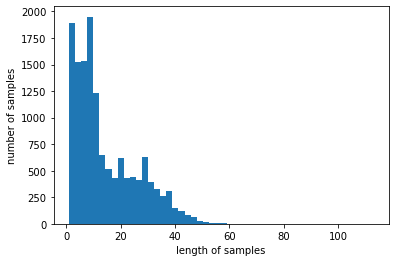

In [13]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in train_sentence))
print('샘플의 평균 길이 : %f' % (sum(map(len, train_sentence))/len(train_sentence)))
plt.hist([len(s) for s in train_sentence], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
max_words = 4000        #문장 데이터에 있는 모든 단어를 사용하지 않고 높은 빈도수를 가진 상위 약 4,000개의 단어만을 사용
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')         #tokenizer 객체 생성
src_tokenizer.fit_on_texts(train_sentence)                              #인덱스 구축 

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(train_tag)

In [15]:
train_sentence[0]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [16]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 10


In [17]:
X_train = src_tokenizer.texts_to_sequences(train_sentence)
y_train = tar_tokenizer.texts_to_sequences(train_tag)

In [18]:
X_valid = src_tokenizer.texts_to_sequences(valid_sentence)
y_valid = tar_tokenizer.texts_to_sequences(valid_tag)

X_test = src_tokenizer.texts_to_sequences(test_sentence)
y_test = tar_tokenizer.texts_to_sequences(test_tag)

In [19]:
X_train[0]

[989, 1, 205, 629, 7, 3939, 216, 1, 3]

In [20]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [21]:
index_to_ner

{1: 'o',
 2: 'b-loc',
 3: 'b-per',
 4: 'b-org',
 5: 'i-per',
 6: 'i-org',
 7: 'b-misc',
 8: 'i-loc',
 9: 'i-misc'}

In [22]:
decoded = []
for index in X_test[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존 문장 : {}'.format(test_sentence[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN', 'SURPRISE', 'DEFEAT', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['soccer', '-', 'japan', 'get', 'OOV', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.']


In [23]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
# X_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)
# y_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자0으로 채움.
X_valid = pad_sequences(X_valid, padding='post', maxlen=max_len)
y_valid = pad_sequences(y_valid, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)
y_test = pad_sequences(y_test, padding='post', maxlen=max_len)

In [24]:
X_train[0]

array([ 989,    1,  205,  629,    7, 3939,  216,    1,    3,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0])

In [25]:
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777) #이미 위에 다른 txt를 사용했기 때문에 필요 없음

In [26]:
y_train[:2]

array([[4, 1, 7, 1, 1, 1, 7, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]])

In [27]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_valid = to_categorical(y_valid, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)           ##원핫 인코딩 시킴 

In [28]:
y_train[0][0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [29]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (14041, 70)
훈련 샘플 레이블의 크기 : (14041, 70, 10)
테스트 샘플 문장의 크기 : (3453, 70)
테스트 샘플 레이블의 크기 : (3453, 70, 10)


In [30]:
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed, Flatten, Input
# from tensorflow.keras.optimizers import Adam
import tensorflow as tf

## 모델 1. 
### - many2many bidirectional LSTM
### - Embedding 사용

In [149]:
model = tf.keras.models.Sequential()        ##vocab_size == max_words == 4000  ##max_len == 70
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True, batch_size=100))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True), merge_mode='concat'))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(tag_size, activation='softmax')))

In [150]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (100, 70, 128)            512000    
_________________________________________________________________
bidirectional_15 (Bidirectio (100, 70, 512)            788480    
_________________________________________________________________
time_distributed_12 (TimeDis (100, 70, 10)             5130      
Total params: 1,305,610
Trainable params: 1,305,610
Non-trainable params: 0
_________________________________________________________________
None


In [151]:
model.fit(X_train, y_train, batch_size=128, epochs=8, validation_data=(X_test, y_test))

ValueError: The `batch_size` argument value 128 is incompatible with the specified batch size of your Input Layer: 100

In [37]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test,verbose=0)[1]))


 테스트 정확도: 0.9277


# ====================================================================================

In [125]:
modelInput = tf.keras.layers.Input(shape=(vocab_size,max_len))
modelInput

<tf.Tensor 'input_5:0' shape=(None, 4000, 70) dtype=float32>

In [128]:
sess= tf.compat.v1.Session() 

In [140]:
print(modelInput.numpy())

AttributeError: 'Tensor' object has no attribute 'numpy'

In [122]:
wordEmbedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, mask_zero=True)(modelInput)
wordEmbedding

<tf.Tensor 'embedding_14/Identity:0' shape=(None, 4000, 70, 128) dtype=float32>

In [112]:
runLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True), merge_mode='concat')(modelInput)
runLSTM

<tf.Tensor 'bidirectional_12/Identity:0' shape=(128, 4000, 512) dtype=float32>

In [113]:
timeDistributedData = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(tag_size, activation='softmax'))(runLSTM)
timeDistributedData

<tf.Tensor 'time_distributed_9/Identity:0' shape=(128, 4000, 10) dtype=float32>

In [114]:
modelFunc = tf.keras.Model(inputs=[modelInput], outputs=timeDistributedData)
modelFunc.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
modelFunc.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words_input (InputLayer)     [(128, 4000, 70)]         0         
_________________________________________________________________
bidirectional_12 (Bidirectio (128, 4000, 512)          669696    
_________________________________________________________________
time_distributed_9 (TimeDist (128, 4000, 10)           5130      
Total params: 674,826
Trainable params: 674,826
Non-trainable params: 0
_________________________________________________________________


In [116]:
modelFunc.fit(X_train, y_train, batch_size=128, epochs=8,  validation_data=(X_test, y_test))

ValueError: Error when checking input: expected words_input to have 3 dimensions, but got array with shape (14041, 70)

In [108]:
print("\n 테스트 정확도: %.4f" % (modelFunc.evaluate(X_test, y_test,verbose=0)[1]))


 테스트 정확도: 0.9326


In [39]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
#model.add(tf.keras.layers.Embedding(batch_input_shape=(None,vocab_size,max_len), output_dim=128, mask_zero=True))
model1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True), merge_mode='concat'))
model1.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(tag_size, activation='softmax')))

TypeError: __init__() missing 1 required positional argument: 'input_dim'

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

In [ ]:
model1.fit(X_train, y_train, batch_size=128, epochs=8,  validation_data=(X_test, y_test))

In [ ]:
print("\n 테스트 정확도: %.4f" % (model1.evaluate(X_test, y_test,verbose=0)[1]))

## 모델 2.
### - TimeDistributed 사용 안함

In [ ]:
model_1 = Sequential()
model_1.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model_1.add(Bidirectional(LSTM(256,input_shape=(max_len,vocab_size), return_sequences=True), merge_mode='concat'))
#model_1.add(TimeDistributed(Dense(tag_size, activation='softmax')))
model_1.add(Dense(10,activation='softmax'))

In [ ]:
model_1.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
print(model_1.summary())

In [ ]:
model_1.fit(X_train, y_train, batch_size=128, epochs=8,  validation_data=(X_test, y_test))

In [ ]:
print("\n 테스트 정확도: %.4f" % (model_1.evaluate(X_test, y_test,verbose=0)[1]))

## 모델 3
### - lambda 사용

In [ ]:
model_2 = Sequential()
model_2.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model_2.add(Bidirectional(LSTM(256,input_shape=(max_len,vocab_size), return_sequences=True), merge_mode='concat'))
model_2.add(Lambda(lambda z=K.mean(z, axis=1)))
#model_1.add(TimeDistributed(Dense(tag_size, activation='softmax')))
model_2.add(Dense(10,activation='softmax'))

In [ ]:
model_1.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
print(model_1.summary())

In [ ]:
model_2 = Sequential()
model_2.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model_2.add(LSTM(256, return_sequences=True))
model_2.add(TimeDistributed(Dense(tag_size, activation='softmax')))

In [ ]:
model_2.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
print(model_2.summary())

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=8,  validation_data=(X_test, y_test))

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

In [ ]:
model_1.fit(X_train, y_train, batch_size=128, epochs=8,  validation_data=(X_test, y_test))

In [ ]:
print("\n 테스트 정확도: %.4f" % (model_1.evaluate(X_test, y_test)[1]))

In [ ]:
i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t].upper(), index_to_ner[pred].upper()))